# Objective: fine-tuning detectron2/DETR

-   This notebook can be found on my Github profile: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).
-   A nice blog post about another approach (Mask R-CNN) and the balloon dataset (which we use in this notebook): [here](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46).

## Install detectron 2

In [ ]:
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Cloning into 'detectron2'...
remote: Enumerating objects: 15285, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 15285 (delta 2), reused 6 (delta 0), pack-reused 15275
Receiving objects: 100% (15285/15285), 6.18 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (11113/11113), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=aba515f9e8e34173a0608f41e40af9b40aa0f3e1354ea5507d176b68ed299d9f
  

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Create DETR config

In [ ]:
#this is the setup to have detr code installed without using pip or conda, direclty have the code itself
#this runs the shell script to set up detr

%cd /content/

!git clone https://github.com/facebookresearch/detr

%cd detr/

!python d2/converter.py --source_model https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth --output_model converted_model.pth

/content
Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/detr
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100% 159M/159M [00:00<00:00, 169MB/s]
transformer.encoder.layers.0.self_attn.in_proj_weight -> detr.transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias -> detr.transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight -> detr.transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias -> detr.transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight -> detr.transformer.encoder.layers.0.linear1.weight
transformer.enco

In [ ]:
from d2.detr import add_detr_config

cfg = get_cfg()

add_detr_config(cfg)
cfg.merge_from_file("d2/configs/detr_256_6_6_torchvision.yaml")

cfg.MODEL.WEIGHTS = "converted_model.pth"

## Define useful boilerplate functions

Adapted from:
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [ ]:
def filter_predictions_from_outputs(outputs,
                                    threshold=0.7,
                                    verbose=True):

  predictions = outputs["instances"].to("cpu")

  if verbose:
    print(list(predictions.get_fields()))

  # Reference: https://github.com/facebookresearch/detectron2/blob/7f06f5383421b847d299b8edf480a71e2af66e63/detectron2/structures/instances.py#L27
  #
  #   Indexing: ``instances[indices]`` will apply the indexing on all the fields
  #   and returns a new :class:`Instances`.
  #   Typically, ``indices`` is a integer vector of indices,
  #   or a binary mask of length ``num_instances``

  indices = [i
            for (i, s) in enumerate(predictions.scores)
            if s >= threshold
            ]

  filtered_predictions = predictions[indices]

  return filtered_predictions

## Load an image for a demo

In [ ]:
url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
!wget $url -q -O input.jpg

im = cv2.imread('input.jpg')

In [ ]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[12/06 03:25:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from converted_model.pth ...


criterion.empty_weight


In [ ]:
print(type(outputs))
print(outputs.keys())
print(type(outputs['instances']))
instances = outputs['instances']
#num_instances -> number of instances detected, image_height&image_weight
# fields:
#pred_boxes->coordinates of predicted boxes
#scores-> probability of each prediction made
#pred classes-> class of the prediction, numerized
fields = instances._fields
print(type(fields))
print(fields.keys())


<class 'dict'>
dict_keys(['instances'])
<class 'detectron2.structures.instances.Instances'>
<class 'dict'>
dict_keys(['pred_boxes', 'scores', 'pred_classes'])


In [ ]:
#only display the pred_classes that has higher score than
threshold = 0.7

filtered_predictions = filter_predictions_from_outputs(outputs,
                                                  threshold=threshold)

['pred_boxes', 'scores', 'pred_classes']


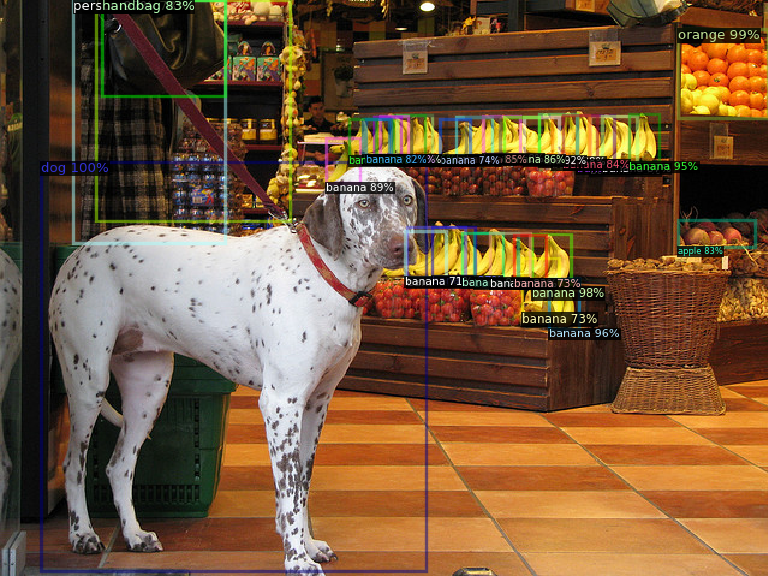

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(filtered_predictions)
cv2_imshow(out.get_image()[:, :, ::-1])

## Prepare the dataset for fine-tuning

The `balloon` dataset will be used. It is featured here and uses VIA format:
-   https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon


You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

NB: this parameter matters a bit with vanilla DETR, but not with detectron2/DETR!

In [ ]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

Clone [my fork](https://github.com/woctezuma/VIA2COCO/tree/fixes) to convert annotations from VIA format to COCO format.

In [ ]:
%cd /content/

!rm -rf VIA2COCO
!git clone https://github.com/woctezuma/VIA2COCO

%cd VIA2COCO/

!git checkout fixes

/content
Cloning into 'VIA2COCO'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 63 (delta 25), reused 36 (delta 20), pack-reused 20
Receiving objects: 100% (63/63), 16.41 KiB | 3.28 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/VIA2COCO
Already on 'fixes'
Your branch is up to date with 'origin/fixes'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We expect the directory structure to be the following:
```
path/to/coco/
├ annotations/  # JSON annotations
│  ├ annotations/custom_train.json
│  └ annotations/custom_val.json
├ train2017/    # training images
└ val2017/      # validation images
```

In [ ]:
!mkdir -p /content/data/custom/annotations/

!mv /content/VIA2COCO/balloon/train/custom_train.json /content/data/custom/annotations/custom_train.json
!mv /content/VIA2COCO/balloon/val/custom_val.json /content/data/custom/annotations/custom_val.json

!mkdir -p /content/data/custom/train2017/

!mv /content/VIA2COCO/balloon/train/*.jpg /content/data/custom/train2017/

!mkdir -p /content/data/custom/val2017/

!mv /content/VIA2COCO/balloon/val/*.jpg /content/data/custom/val2017/

- Documentation: https://detectron2.readthedocs.io/tutorials/datasets.html

In [ ]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("OH_train",
                        {},
                        "/content/data/poles/annotations/oh_region_train.json",
                        "/content/data/poles/train2017/")

register_coco_instances("OH_val",
                        {},
                        "/content/data/poles/annotations/oh_region_val.json",
                        "/content/data/poles/val2017/")

In [ ]:
cat_names = ["OH","UG"]

for keyword in ['train', 'val']:
  MetadataCatalog.get('OH_{}'.format(keyword)).set(thing_classes=cat_names)

custom_metadata = MetadataCatalog.get("OH_train")

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

[12/06 03:33:57 d2.data.datasets.coco]: Loaded 75 images in COCO format from /content/data/poles/annotations/oh_region_train.json


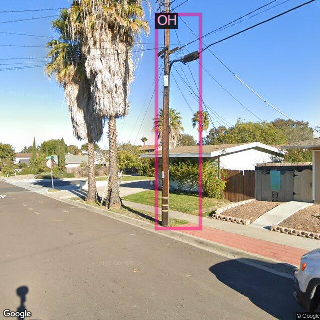

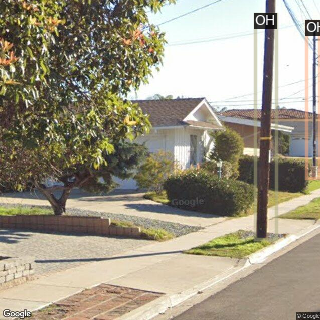

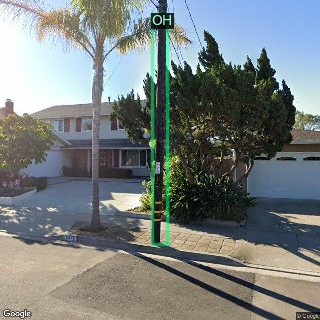

In [ ]:
dataset_dicts = DatasetCatalog.get("OH_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=custom_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])